In [1]:
import sys
sys.path.append('..\\src')
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np

---
### Set up data

In [3]:
from dce import fit, relax, signal_models, water_ex_models

# DCE data (subject 4)
t = np.array([19.810000,59.430000,99.050000,138.670000,178.290000,217.910000,257.530000,297.150000,336.770000,376.390000,416.010000,455.630000,495.250000,534.870000,574.490000,614.110000,653.730000,693.350000,732.970000,772.590000,812.210000,851.830000,891.450000,931.070000,970.690000,1010.310000,1049.930000,1089.550000,1129.170000,1168.790000,1208.410000,1248.030000])
s_vif = np.array([411.400000,420.200000,419.600000,399.000000,1650.400000,3229.200000,3716.200000,3375.600000,3022.000000,2801.200000,2669.800000,2413.800000,2321.400000,2231.400000,2152.800000,2138.200000,2059.200000,2037.600000,2008.200000,1998.800000,1936.800000,1939.400000,1887.000000,1872.800000,1840.200000,1820.400000,1796.200000,1773.000000,1775.600000,1762.000000,1693.400000,1675.800000])
s_tissue = np.array([378.774277,380.712810,378.789773,382.467975,407.950413,443.482955,446.239153,433.392045,425.428202,426.274793,420.676653,417.144112,410.072831,422.042355,414.013430,410.885847,405.251033,415.864669,418.615186,406.327479,408.692149,406.797004,418.646694,408.176136,404.993285,405.098140,417.022211,408.189050,409.819731,401.988636,405.866219,406.299587])
r0_tissue = relax.relaxation(r_1 = 1./1.3651, r_2s = 0.)
r0_vif = relax.relaxation(r_1 = 1./1.7206, r_2s = 0.)
k_vif, k_tissue = 0.9946, 1.2037
hct = 0.46
tr, fa_rad, te = 3.4e-3, 15.*(np.pi/180.), 1.7e-3

# time points to use for baseline
baseline_idx = [0,1,2]

# specify relaxivity
rlxy = relax.relaxivity(r_1 = 5.0, r_2s = 7.1)
# specify conc to relaxation rate model
c_to_r_model = relax.c_to_r_linear(rlxy)
# specify signal model
signal_model = signal_models.spgr(tr, fa_rad, te)

### Convert signal to enhancement

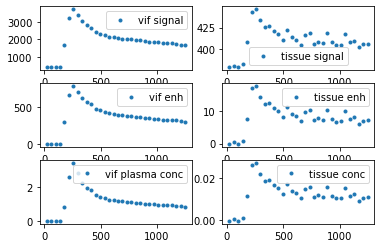

In [9]:
from dce import fit
enh_vif = fit.s_to_e(s_vif, baseline_idx)
enh_tissue = fit.s_to_e(s_tissue, baseline_idx)

c_p_vif = fit.e_to_c(enh_vif, k_vif, r0_vif, c_to_r_model, signal_model) / (1 - hct)
c_t = fit.e_to_c(enh_tissue, k_tissue, r0_tissue, c_to_r_model, signal_model)

fig, ax = plt.subplots(3,2)
ax[0,0].plot(t, s_vif, '.', label='vif signal')
ax[0,1].plot(t, s_tissue, '.', label='tissue signal')
ax[1,0].plot(t, enh_vif, '.', label='vif enh')
ax[1,1].plot(t, enh_tissue, '.', label='tissue enh')
ax[2,0].plot(t, c_p_vif, '.', label='vif plasma conc')
ax[2,1].plot(t, c_t, '.', label='tissue conc')
[a.legend() for a in ax.flatten()];

### Fit tissue concentration to pharmacokinetic model

{'vp': 0.008012025270359274, 'ps': 0.00020114799448489856, 've': 0.9851629161660014, 'vi': 0.0, 'vb': 0.014837083833998654}


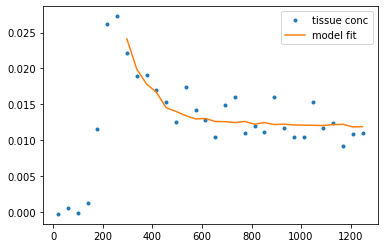

In [11]:
from dce import fit, aifs, pk_models

#c_t = np.array([-0.000310,0.000490,-0.000210,0.001190,0.011598,0.026225,0.027290,0.022144,0.018885,0.019074,0.016927,0.015324,0.012559,0.017440,0.014151,0.012811,0.010499,0.014873,0.015946,0.010926,0.011949,0.011145,0.015946,0.011714,0.010395,0.010499,0.015324,0.011714,0.012434,0.009190,0.010817,0.010926])
#c_p_vif = np.array([-0.003168,0.001647,0.001462,-0.009834,0.819594,2.625424,3.503638,2.871388,2.306862,2.006884,1.834974,1.534070,1.445164,1.347930,1.269811,1.257239,1.184376,1.161039,1.126893,1.126893,1.061584,1.072200,1.020162,1.010061,0.980355,0.961038,0.942102,0.923539,0.923539,0.914395,0.852873,0.844428])

aif = aifs.patient_specific(t, c_p_vif)
dt_interp_request = t[1]-t[0]

pk_model = pk_models.patlak(t, dt_interp_request, aif, hct) 
fit_opts = {'pk_pars_0': {'vp': 0.2, 'ps': 1e-4},
            't_mask': np.array(np.concatenate([np.zeros(7), np.ones(25)]),dtype=bool) }

pk_pars, c_tissue_fit = fit.c_to_pkp(c_t, pk_model, fit_opts)

print(pk_pars)

fig, ax = plt.subplots()
ax.plot(t, c_t, '.', label='tissue conc')
ax.plot(t, c_tissue_fit, '-', label='model fit')
ax.legend();

# expected values for FXL fit:
# Patlak (multiple linear regression): vp = 0.0080, ps = 2.01e-4
# Patlak (non-linear): vp = 0.0080, ps = 2.01e-4
# Patlak plot: vp = 0.0087, ps = 1.61e-4